In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext pycodestyle_magic

Using TensorFlow backend.


In [4]:
sel_columns = [' Meas_5', ' Meas_6',' Meas_10']
v1 = pd.read_csv('example_data_new/v1_obfs.csv', usecols=sel_columns)
v2 = pd.read_csv('example_data_new/v2_obfs.csv', usecols=sel_columns)
v4 = pd.read_csv('example_data_new/v4_obfs.csv', usecols=sel_columns)
v = []

In [39]:
n = v.shape[0]

5258

In [52]:
v_1_2_4.shape

(8753, 9)

In [53]:
n = min([v.shape[0] for v in [v1, v2, v4]])
v = [v1, v2, v4]
v_names = ['v1', 'v2', 'v4']

v_1_2_4 = pd.concat([v1.add_prefix('v1_')[:n],
                     v2.add_prefix('v2_'),
                     v4.add_prefix('v4_')],
                     axis=1, sort=False)

### Functions

In [54]:
def sliding_window_2d(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    xy = []
    line_size = data.shape[1]
    for row in range(0, data.shape[0]):
        for start in range(0, line_size, step_size):
            stop =  start+train_size+test_size
            if stop <= line_size:
                xy.append(data[row, start: stop])
    return np.array(xy)


def xy_split(data, train_size):
    """split sliding windows into X and Y,
       input and output of the model.
    """
    x, y = data[:, :train_size], data[:, train_size:]
    return x, y


def norm_ts(data, transpose=True):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    if transpose:
        scaled01 = scaler.fit_transform(data.T).T
    else:
        scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None

def model_mae_n(model, x_test, y_test, scaler, n, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


### Let's plot selected columns

In [55]:
v_1_2_4.columns

Index(['v1_ Meas_5', 'v1_ Meas_6', 'v1_ Meas_10', 'v2_ Meas_5', 'v2_ Meas_6',
       'v2_ Meas_10', 'v4_ Meas_5', 'v4_ Meas_6', 'v4_ Meas_10'],
      dtype='object')

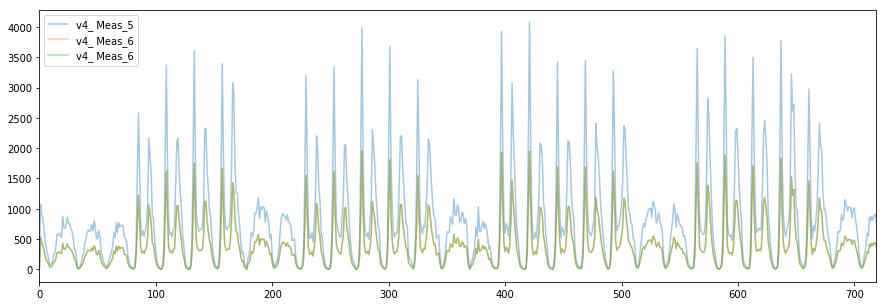

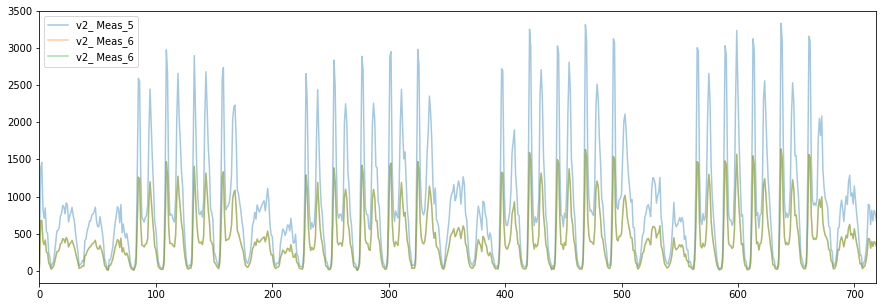

In [56]:
# v_1_2_4.plot(figsize=(15,5), alpha=.4);
v_1_2_4[['v4_ Meas_5', 'v4_ Meas_6', 'v4_ Meas_6']][:720].plot(figsize=(15,5), alpha=.4);
v_1_2_4[['v2_ Meas_5', 'v2_ Meas_6', 'v2_ Meas_6']][:720].plot(figsize=(15,5), alpha=.4);

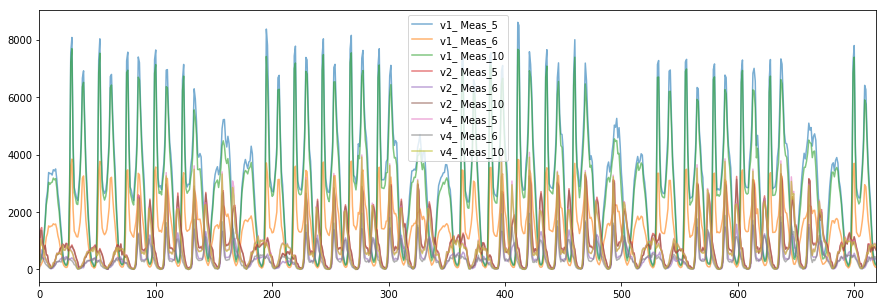

In [57]:
v_1_2_4[:720].plot(figsize=(15,5), alpha=.6);

### Parameters of Sliding Window

In [58]:
v_1_2_4.shape

(5258, 9)

In [64]:

train_size = 168
test_size = 24
train_test_size = train_size + test_size
line_size = v1.shape[1]
step_size = 1
train_vs_test = .75
train_test_split = int(train_vs_test * v_1_2_4.shape[0])

### Normalization

In [65]:
data= v_1_2_4.values.T
data.shape
train_test_split

3943

In [67]:
data= v_1_2_4.values.T

train_xy = data[:, :train_test_split]

test_xy = data[:, train_test_split:]

train_xy, scaler = norm_ts(train_xy)


train_xy = sliding_window_2d(data=train_xy,
                             train_size=train_size,
                             test_size=test_size,
                             step_size=step_size)

test_xy.shape

test_xy = sliding_window_2d(data=test_xy,
                            train_size=train_size,
                            test_size=test_size,
                            step_size=step_size)

test_x_original, test_y_original = xy_split(test_xy, train_size)
test_x, scaler_test = norm_ts(test_x_original, transpose=True)


train_x, train_y = xy_split(train_xy, train_size)
train_x, test_x = train_test_reshape(train_x, test_x)

print (train_x.shape, test_x.shape, test_x_original.shape, test_y_original.shape)

(33768, 168, 1) (10116, 168, 1) (10116, 168) (10116, 24)


### CNN network

In [68]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [69]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 23637 samples, validate on 10131 samples
Epoch 1/20
 - 7s - loss: 0.0147 - mean_absolute_error: 0.0753 - val_loss: 0.0073 - val_mean_absolute_error: 0.0515
Epoch 2/20
 - 7s - loss: 0.0087 - mean_absolute_error: 0.0571 - val_loss: 0.0057 - val_mean_absolute_error: 0.0431
Epoch 3/20
 - 7s - loss: 0.0070 - mean_absolute_error: 0.0501 - val_loss: 0.0049 - val_mean_absolute_error: 0.0394
Epoch 4/20
 - 7s - loss: 0.0061 - mean_absolute_error: 0.0463 - val_loss: 0.0044 - val_mean_absolute_error: 0.0369
Epoch 5/20
 - 7s - loss: 0.0055 - mean_absolute_error: 0.0438 - val_loss: 0.0041 - val_mean_absolute_error: 0.0357
Epoch 6/20
 - 8s - loss: 0.0051 - mean_absolute_error: 0.0420 - val_loss: 0.0039 - val_mean_absolute_error: 0.0346
Epoch 7/20
 - 7s - loss: 0.0048 - mean_absolute_error: 0.0406 - val_loss: 0.0037 - val_mean_absolute_error: 0.0338
Epoch 8/20
 - 9s - loss: 

### Comparison to Naive model

In [88]:
# s = 3000
# n = 4000
naive_prediction_mae(x_test=test_x_original[s:n,:], y_test=test_y_original[s:n,:])

naive model = 384.9565


In [70]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)


naive model = 1476.6241
current model = 533.8505


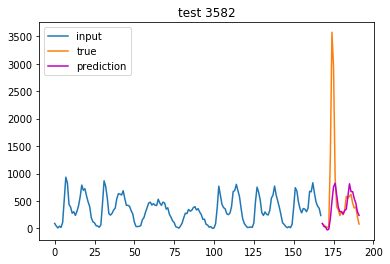

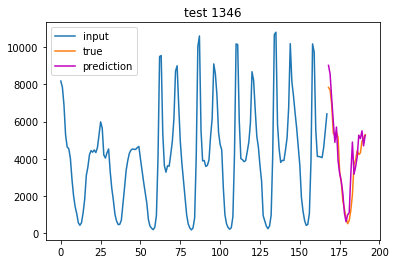

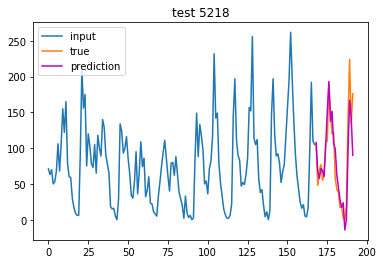

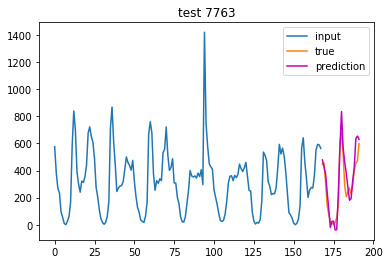

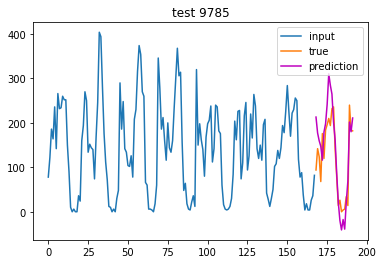

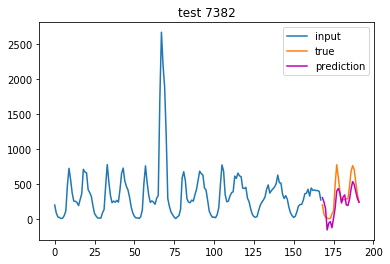

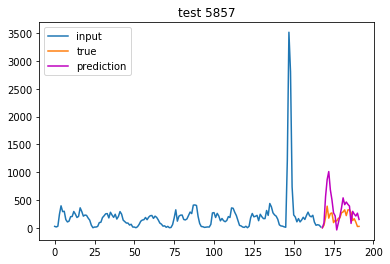

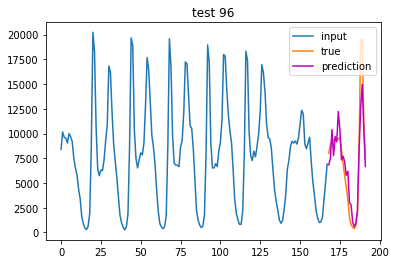

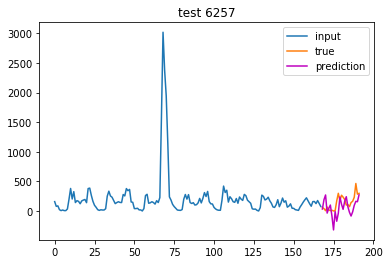

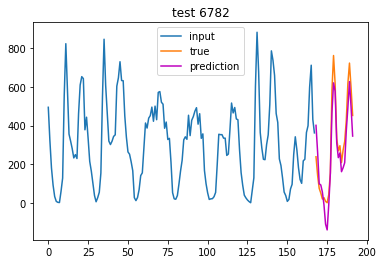

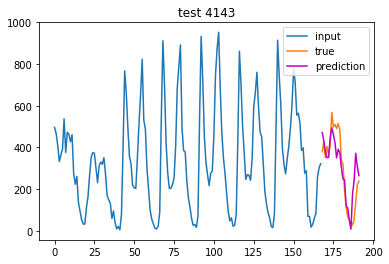

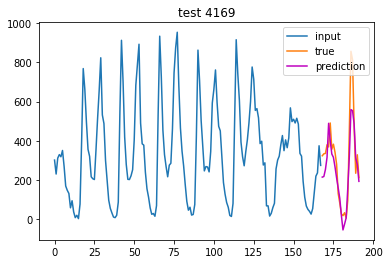

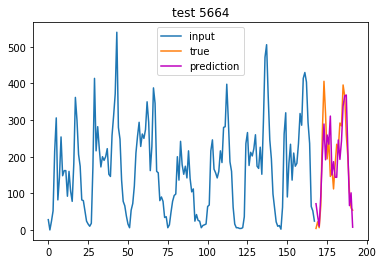

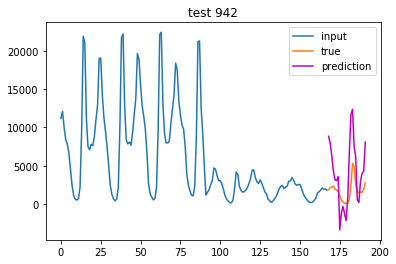

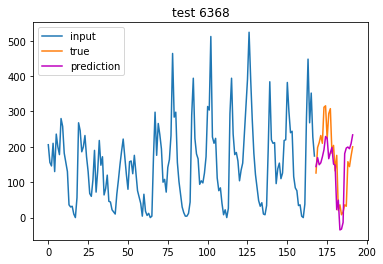

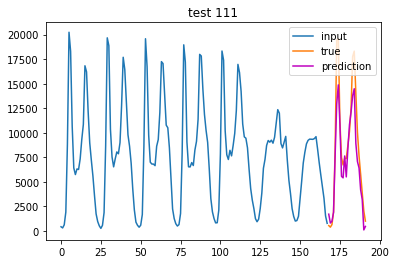

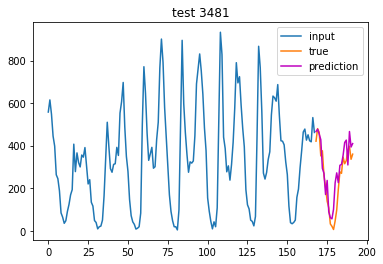

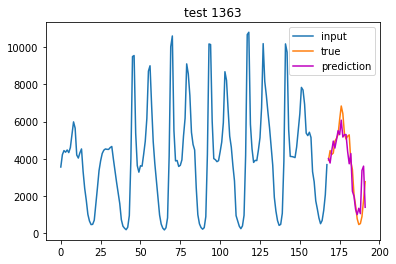

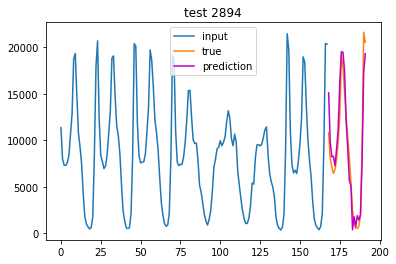

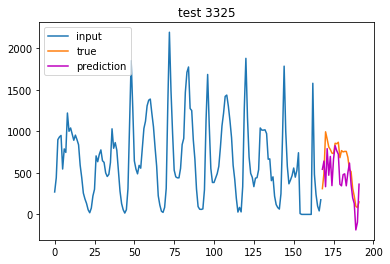

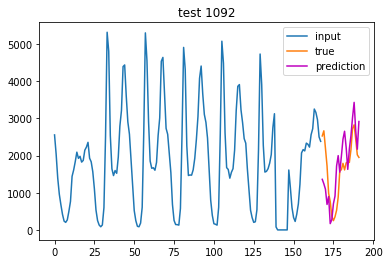

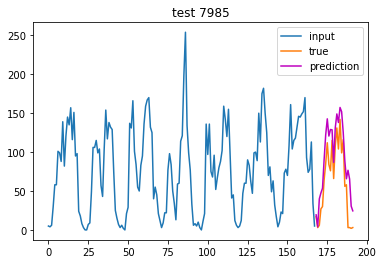

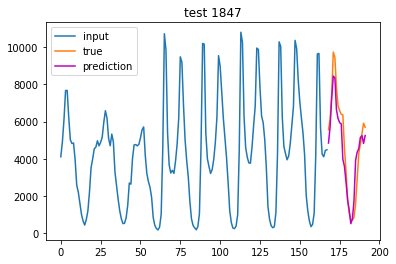

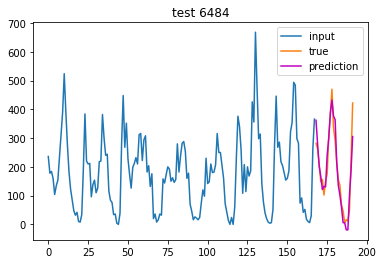

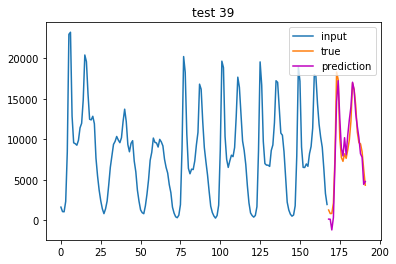

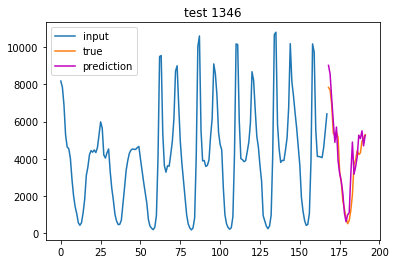

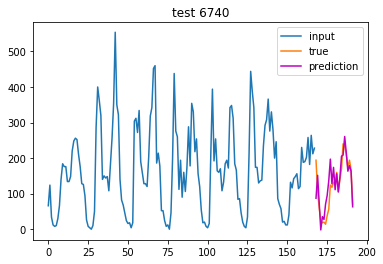

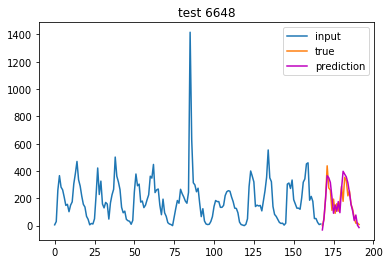

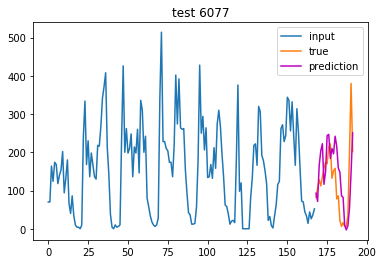

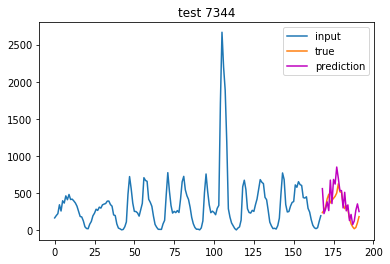

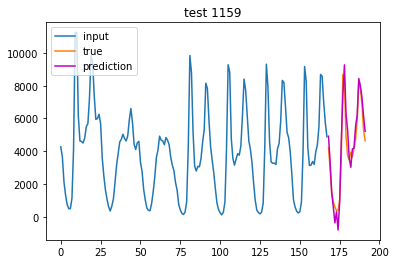

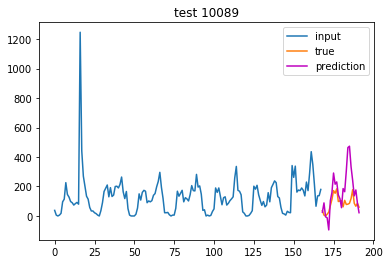

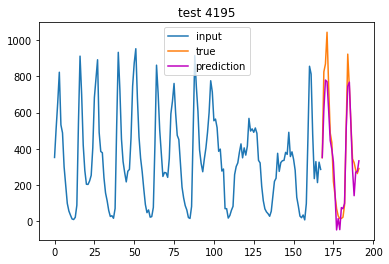

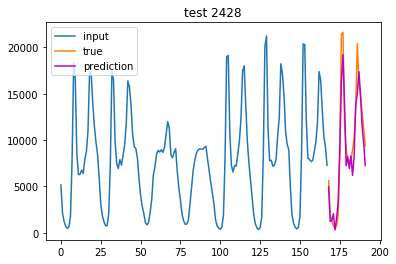

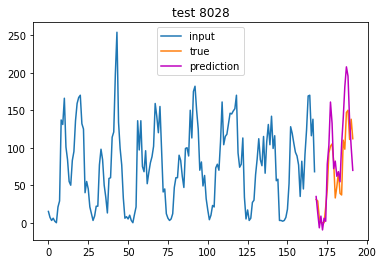

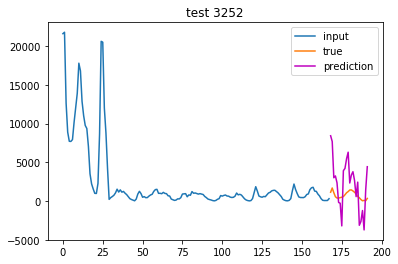

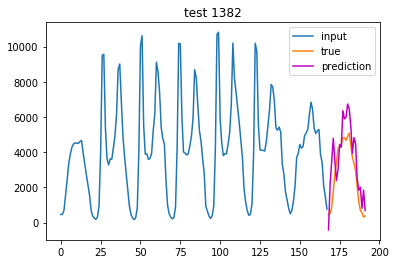

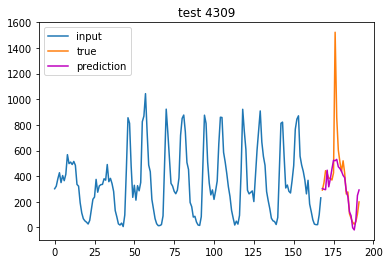

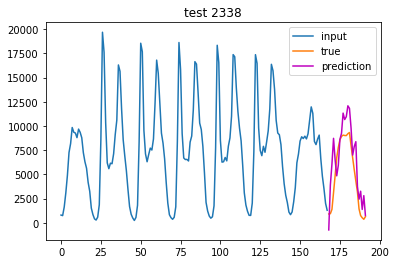

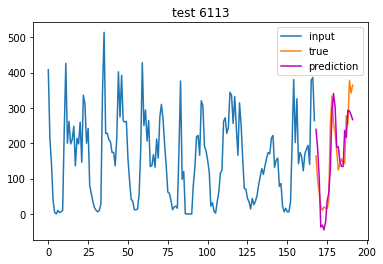

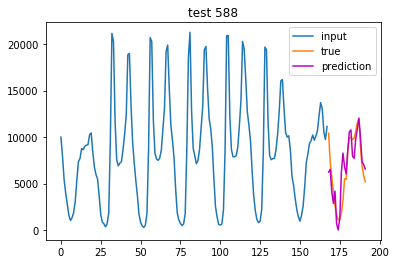

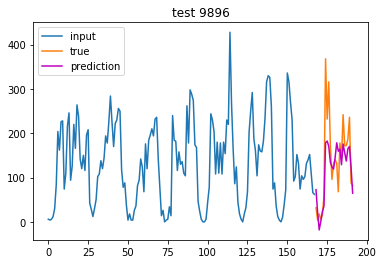

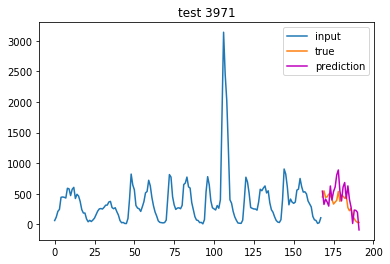

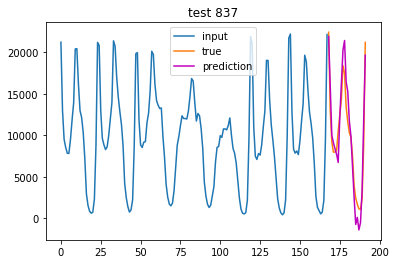

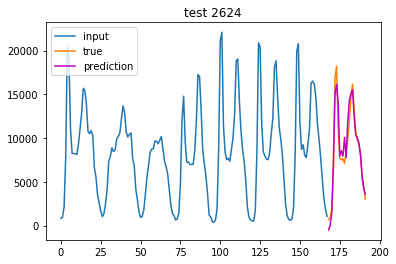

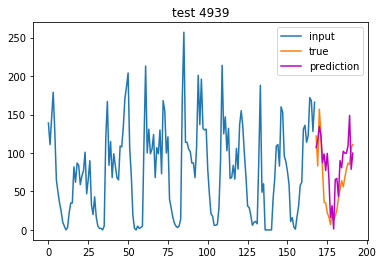

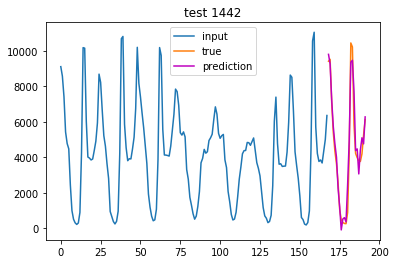

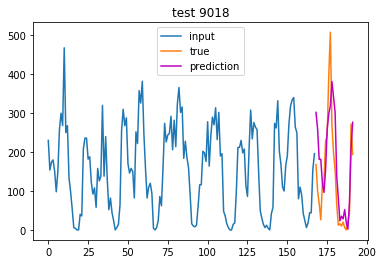

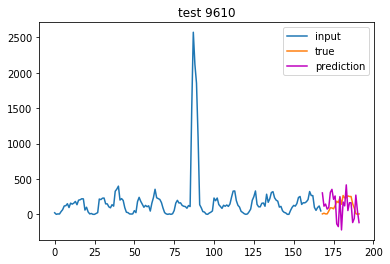

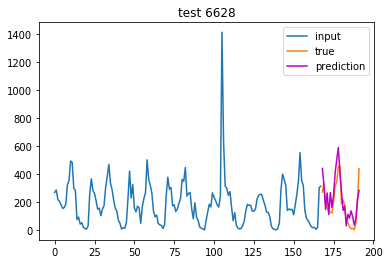

In [71]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title(f'test {i}')
    plt.legend()

### Let's check on the same data as in `V1 ['Meas 5']`

#### Last result:

In [90]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)


naive model = 850.7635
current model = 437.0237


In [72]:
n = int(test_x_original.shape[0] / 6)
naive_prediction_mae(x_test=test_x_original[:n,:], y_test=test_y_original[:n,:])
model_mae_n(model, x_test=test_x, y_test=test_y_original[:n,:],
          scaler=scaler_test, n=n, inv_norm=True)


naive model = 4396.3150
current model = 1358.7378


### The results when we train only on 1 column:

```
naive model = 1538.0077
current model = 721.9249
```

In [110]:
(721-642)/642

0.12305295950155763